In [1]:
import pandas as pd
import nltk
import numpy as np

# Sentiment Analysis
- Unsupervised model
- Supervised model

### Unsupervised Model

In [2]:
hotstar_path = 'https://github.com/skathirmani/datasets/raw/master/hotstar.allreviews_Sentiments.csv'
hotstar = pd.read_csv(hotstar_path)
hotstar.head()

HTTPError: HTTP Error 404: Not Found

In [4]:
hotstar.shape

(5053, 13)

In [5]:
hotstar['Sentiment_Manual'].value_counts()

Neutral     1738
Positive    1733
Negative    1582
Name: Sentiment_Manual, dtype: int64

In [7]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [11]:
#nltk.download('vader_lexicon')

In [10]:
senti = SentimentIntensityAnalyzer()

In [12]:
senti.polarity_scores('i love india')

{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}

In [13]:
senti.polarity_scores('i love india')['compound']

0.6369

In [18]:
hotstar['sentiment_vader'] = hotstar['Reviews'].apply(lambda v: 
                                                      senti.polarity_scores(v)['compound'])

In [24]:
#hotstar['sentiment_vader'].plot.density()

In [25]:
def assign_sentiment(v):
    if v > 0.25:
        return 'Positive'
    elif v < -0.25:
        return 'Negative'
    else:
        return 'Neutral'
hotstar['sentiment_vader'] = hotstar['sentiment_vader'].apply(assign_sentiment)
hotstar['sentiment_vader'].value_counts()

Neutral     2149
Positive    2137
Negative     767
Name: sentiment_vader, dtype: int64

## Supervised Models

### Random Forest

In [36]:
#hotstar.columns
custom_stop_words = []
common_stop_words = nltk.corpus.stopwords.words('english')
stop_words_all = np.hstack([custom_stop_words, common_stop_words])
len(stop_words_all)

from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
stemmer = PorterStemmer()

In [120]:
docs = hotstar['Reviews']
docs = docs.str.lower()
docs = docs.str.replace('[^a-z#@ ]', '')
docs = docs.str.split(' ')
words_rows = docs.tolist()
words_all = []
words_rows_clean = []
docs_clean = []
for row in words_rows:
    row_words = [stemmer.stem(word) for word in row if word not in stop_words_all]  
    words_rows_clean.append(row_words)
    docs_clean.append(' '.join(row_words))
    words_all.extend(row_words)

    
model_dtm = CountVectorizer()
sparse_matrix = model_dtm.fit_transform(docs_clean)
dtm = pd.DataFrame(sparse_matrix.toarray(),
                   columns=model_dtm.get_feature_names())
dtm.shape

(5053, 6152)

### Split data

In [70]:
from sklearn.model_selection import train_test_split
train_x, test_x = train_test_split(dtm, test_size=0.2, random_state=0)

train_y = hotstar.iloc[train_x.index]['Sentiment_Manual']
test_y = hotstar.iloc[test_x.index]['Sentiment_Manual']

In [52]:
#test_y.value_counts() / test_y.shape[0] * 100

In [53]:
#train_y.value_counts() / train_y.shape[0] * 100

## Build Model

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [112]:
model_rf = RandomForestClassifier()
model_rf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Predict Sentiment

In [59]:
test_y_rf = model_rf.predict(test_x)

### Evaluate Model

In [61]:
(test_y == test_y_rf).sum() / test_y.shape[0] * 100

73.39268051434223

In [65]:
test_hotstar = hotstar.iloc[test_y.index]
(test_hotstar['Sentiment_Manual'] == 
 test_hotstar['sentiment_vader']).sum() / test_hotstar.shape[0] * 100

55.78635014836796

In [71]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
model = AdaBoostClassifier()
model.fit(train_x, train_y)
test_y_pred = model.predict(test_x)
(test_y_pred == test_y).sum() / test_y.shape[0] * 100

68.34817012858556

In [72]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(train_x, train_y)
test_y_pred = model.predict(test_x)
(test_y_pred == test_y).sum() / test_y.shape[0] * 100

62.710187932739856

# Twitter API (REST API)

In [73]:
# !pip install tweepy
import tweepy
tweepy.__version__

'3.6.0'

In [81]:
api_key = ''
api_secret = ''
access_token = ''
access_secret = ''

In [84]:
api = tweepy.OAuthHandler(api_key, api_secret)
api.set_access_token(access_token, access_secret)

api_auth = tweepy.API(api)

In [86]:
flipkart_tweets = api_auth.search('#flipkart')

In [87]:
len(flipkart_tweets)

13

In [89]:
type(flipkart_tweets)

tweepy.models.SearchResults

In [91]:
flipkart_tweets[0].text

'@bidbud68 And #Multichoice #Flipkart #Naspers'

In [92]:
flipkart_tweets[0].created_at

datetime.datetime(2018, 11, 7, 6, 47, 58)

In [ ]:
# https://github.com/skathirmani/text-analytics

In [102]:
flipkart_tweets = api_auth.search('#flipkart', count=100)
flipkart_df = pd.DataFrame(columns=['text', 'created_at', 'name'])
for tweet in flipkart_tweets:
    curr_row = {'text': tweet.text,
                'created_at': tweet.created_at,
                'name': tweet.user.name}
    flipkart_df = flipkart_df.append(curr_row, ignore_index=True)

In [114]:
flipkart_df.head()

,text,created_at,name
0,RT @nutramantra: Happy Diwali. Stay Happy &amp...,2018-11-07 07:04:41,jig
1,@Flipkart I was suppose to get my order by 7th...,2018-11-07 07:01:25,Utpal Yadav
2,@narendramodi @ITBP_official कुछ secular लोग #...,2018-11-07 06:54:24,Sumesh Raj
3,@flipkartsupport Not #expected this #type of #...,2018-11-07 06:53:32,Siddiqui Farhan 🇮🇳
4,@bidbud68 And #Multichoice #Flipkart #Naspers,2018-11-07 06:47:58,Zenzo L


In [118]:
hotstar_tweets = api_auth.search('#hotstar', count=500)
hotstar_df = pd.DataFrame(columns=['text', 'created_at', 'name'])
for tweet in hotstar_tweets:
    curr_row = {'text': tweet.text,
                'created_at': tweet.created_at,
                'name': tweet.user.name}
    hotstar_df = hotstar_df.append(curr_row, ignore_index=True)

In [119]:
hotstar_df.shape

(100, 3)

In [117]:
hotstar.to_csv('hotstar_tweets.csv', index=False)

### Predicting sentiment for new tweets

In [161]:
docs_new = hotstar_df['text'].str.lower()
docs_new = docs_new.str.replace('[^a-z#@ ]', '')
docs_new = docs_new.str.split(' ')
words_rows = docs_new.tolist()

docs_clean_new = []
for row in words_rows:
    row_words = [stemmer.stem(word) for word in row if word not in stop_words_all]  
    docs_clean_new.append(' '.join(row_words))

model_new = CountVectorizer(vocabulary=model_dtm.vocabulary_)
dtm_new = pd.DataFrame(model_new.fit_transform(docs_clean_new).toarray(),
                      columns=model_dtm.get_feature_names())

In [151]:
len(model_rf.predict(dtm_new))

100

In [133]:
# len(model_dtm.get_feature_names())
#np.sort(list(model_dtm.vocabulary_.values()))

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

## Term Frequency - Inverse Document Frequency (TF - IDF)

In [188]:
from sklearn.feature_extraction.text import TfidfVectorizer
model_train_tfidf = TfidfVectorizer()
dtm_tfidf = pd.DataFrame(model_train_tfidf.fit_transform(docs_clean).toarray(),
                         columns=model_train_tfidf.get_feature_names())

train_x, test_x = train_test_split(dtm_tfidf, test_size=0.2, random_state=0)

train_y = hotstar.iloc[train_x.index]['Sentiment_Manual']
test_y = hotstar.iloc[test_x.index]['Sentiment_Manual']

model_rf2 = RandomForestClassifier()
model_rf2.fit(train_x, train_y)

pred = model_rf2.predict(test_x)
(pred == test_y).sum() / test_y.shape[0] * 100

74.77744807121661

74.4807121661721

### Exercises

### Understanding Customer's concern
- For amazon reviews data, identify bigrams
- Identify sentiment for each bigram
- By visual inspection (i.e. manually) see kind of words associated with negative bigrams
- This generally helps you to idenfify segments of products in which users do generally complain (understanding customer's concern)

### Document Clustering
- For amazon reviews data, get the Document Term Matrix after cleaning
- Use K-means clustering for cluster the reviews in to five groups
- Plot a bar chart to display no. of documents under each group
- Create Word cloud for each group

### Trending of Sentiments
- Using hotstar labeled data create multi-line chart using matplotlib
- X axis is date
- Y axis is no. of tweets
- Have one line for each sentiment in the Sentiment_Manual column (green color for positive reviews, red for negative reviews, gray for neural)


In [203]:
amazon_data_path = 'https://github.com/skathirmani/datasets/raw/master/amazon_reviews_11.zip'
amazon = pd.read_csv(amazon_data_path)
amazon['reviewText'] = amazon['reviewText'].fillna('')
docs = amazon['reviewText']
docs = docs.str.lower()
docs = docs.str.replace('[^a-z#@ ]', '')
docs = docs.str.split(' ')
words_rows = docs.tolist()
words_all = []
words_rows_clean = []
docs_clean = []
for row in words_rows:
    row_words = [stemmer.stem(word) for word in row if word not in stop_words_all]  
    words_rows_clean.append(row_words)
    docs_clean.append(' '.join(row_words))
    words_all.extend(row_words)

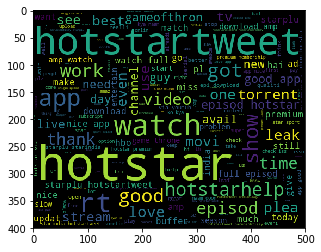

In [210]:
# !pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc_plt = WordCloud().generate(' '.join(docs_clean))
plt.imshow(wordcloud) 